In [27]:
# Step 1: Extraction from PDF
# pip install PyPDF2
# pip install pytesseract
# pip install pdfminer.six
from PyPDF2 import PdfReader



In [29]:
import os
from PyPDF2 import PdfReader

# Function to extract text from a single PDF file
def extract_text_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text()
    return text

# Function to extract text from all PDFs in a directory
def extract_text_from_directory(directory_path, output_folder):
    if not os.path.exists(output_folder):  # Create output folder if it doesn't exist
        os.makedirs(output_folder)
    
    pdf_files = [f for f in os.listdir(directory_path) if f.endswith(".pdf")]
    if not pdf_files:
        print("No PDF files found in the directory.")
        return

    for pdf_file in pdf_files:
        pdf_path = os.path.join(directory_path, pdf_file)
        print(f"Processing: {pdf_file}")
        
        # Extract text and save it to a .txt file
        text = extract_text_from_pdf(pdf_path)
        output_file = os.path.join(output_folder, f"{os.path.splitext(pdf_file)[0]}.txt")
        with open(output_file, "w", encoding="utf-8") as f:
            f.write(text)
        print(f"Saved extracted text to: {output_file}")

# Specify the directory containing the PDFs and where to save the output
input_directory = "/Users/jenniferkels/Desktop/pdfs"  # Folder with PDF files
output_directory = "/Users/jenniferkels/Desktop/extracted_texts"  # Folder to save text files

# Extract text from all PDFs in the directory
extract_text_from_directory(input_directory, output_directory)


Processing: 49.pdf
Saved extracted text to: /Users/jenniferkels/Desktop/extracted_texts/49.txt
Processing: 60.pdf
Saved extracted text to: /Users/jenniferkels/Desktop/extracted_texts/60.txt
Processing: 89.pdf
Saved extracted text to: /Users/jenniferkels/Desktop/extracted_texts/89.txt
Processing: 63.pdf
Saved extracted text to: /Users/jenniferkels/Desktop/extracted_texts/63.txt
Processing: 73.pdf
Saved extracted text to: /Users/jenniferkels/Desktop/extracted_texts/73.txt
Processing: 9.pdf
Saved extracted text to: /Users/jenniferkels/Desktop/extracted_texts/9.txt
Processing: 8.pdf
Saved extracted text to: /Users/jenniferkels/Desktop/extracted_texts/8.txt
Processing: 16.pdf
Saved extracted text to: /Users/jenniferkels/Desktop/extracted_texts/16.txt
Processing: 114.pdf
Saved extracted text to: /Users/jenniferkels/Desktop/extracted_texts/114.txt
Processing: 15.pdf
Saved extracted text to: /Users/jenniferkels/Desktop/extracted_texts/15.txt
Processing: 14.pdf
Saved extracted text to: /Users/j

In [93]:
# Step 2. Entity and Relation Extraction
# Entity Recognition: Identify entities like names, dates, or organizations.
# Use spaCy (pretrained NLP models):
# pip install spacy
# python -m spacy download en_core_web_sm
import os
import spacy
import pandas as pd

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Folder where extracted text files are located
folder_path = "/Users/jenniferkels/Desktop/extracted_texts"  # Update with your folder path

# List to store extracted entities
entity_data = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    # Make sure it's a text file (you can adapt this for other formats like .pdf or .docx)
    if filename.endswith(".txt"):
        file_path = os.path.join(folder_path, filename)

        # Read the content of the file
        with open(file_path, "r") as file:
            text = file.read()

        # Process the text with spaCy NLP model
        doc = nlp(text)

        # Extract and store entities for the current file
        for ent in doc.ents:
            entity_data.append([filename, ent.text, ent.label_])

# Create a DataFrame to organize the extracted data
df = pd.DataFrame(entity_data, columns=["File Name", "Entity", "Label"])

# Drop duplicates to avoid redundant entries
df = df.drop_duplicates()

# Save to CSV
df.to_csv("/Users/jenniferkels/Desktop/extracted_entities.csv", index=False)

# Print out the first few rows of the DataFrame
print(df.head())



  File Name                           Entity     Label
0    15.txt                   UNITED NATIONS       ORG
1    15.txt                           Kosovo       GPE
2    15.txt  Intérimaire des Nations \nUnies       ORG
4    15.txt                  14KJanuaryK2005  CARDINAL
5    15.txt                K \n K\nREFERENCE       ORG


In [88]:
import os
import spacy
import pandas as pd
from spacy.tokenizer import Tokenizer
from spacy.util import compile_infix_regex

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Custom tokenizer that treats 'K' as a delimiter (removes 'K' entirely)
infixes = list(nlp.Defaults.infixes)
infixes.append(r'K')  # Add 'K' as an infix (delimiter) in the tokenizer
infix_re = compile_infix_regex(infixes)
nlp.tokenizer = Tokenizer(nlp.vocab, infix_finditer=infix_re.finditer)

# Folder where extracted text files are located
folder_path = "/Users/jenniferkels/Desktop/extracted_texts"  # Update with your folder path

# List to store extracted entities
entity_data = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    # Make sure it's a text file
    if filename.endswith(".txt"):
        file_path = os.path.join(folder_path, filename)

        # Read the content of the file
        with open(file_path, "r") as file:
            text = file.read()

        # Process the text with spaCy NLP model
        doc = nlp(text)

        # Clean up the text after tokenization to remove the 'K' tokens
        cleaned_text = ' '.join([token.text for token in doc if token.text != 'K'])

     
        # Process the cleaned text again with spaCy
        doc_cleaned = nlp(cleaned_text)

        # Extract and store entities for the current file
        for ent in doc_cleaned.ents:
            entity_data.append([filename, ent.text, ent.label_])

# Create a DataFrame to organize the extracted data
df = pd.DataFrame(entity_data, columns=["File Name", "Entity", "Label"])

# Debugging: Print a few entities before cleaning to see where the 'k' is coming from
print("Original Extracted Entities (Before Cleaning):")
print(df.head())

# Data cleaning steps
# 1. Remove rows where entity text is empty
df = df[df['Entity'].str.strip() != '']

# 2. Remove unwanted characters like \n, extra spaces, and potential hidden characters
df['Entity'] = df['Entity'].str.replace(r'\n', ' ', regex=True).str.strip()

# Debugging: Check for non-alphanumeric characters and extra spaces
df['Entity'] = df['Entity'].apply(lambda x: ''.join(e for e in x if e.isalnum() or e.isspace()))  # Remove non-alphanum

# 3. Optional: Standardize case for consistency (e.g., convert all entity text to lowercase)
df['Entity'] = df['Entity'].str.lower()

# 4. Optional: Standardize labels as well (e.g., convert to uppercase)
df['Label'] = df['Label'].str.upper()

# Drop duplicates to avoid redundant entries
df = df.drop_duplicates()

# Save to CSV
df.to_csv("/Users/jenniferkels/Desktop/extracted_entities_cleaned_v2.csv", index=False)

# Print out the first few rows of the cleaned DataFrame to confirm the cleaning
print("Cleaned Extracted Entities:")
print(df.head())




Original Extracted Entities (Before Cleaning):
  File Name                                            Entity Label
0    15.txt                                    UNITED NATIONS   ORG
1    15.txt  United Nations Interim \n Administration Mission   ORG
2    15.txt                                            Kosovo   GPE
3    15.txt                                            Kosovo   GPE
4    15.txt                                             DATE:   GPE
Cleaned Extracted Entities:
  File Name                                           Entity Label
0    15.txt                                   united nations   ORG
1    15.txt  united nations interim   administration mission   ORG
2    15.txt                                           kosovo   GPE
4    15.txt                                             date   GPE
5    15.txt                                  14 january 2005  DATE


In [70]:
import pandas as pd

# Load the cleaned data (assuming you saved it as CSV)
df = pd.read_csv("/Users/jenniferkels/Desktop/extracted_entities_cleaned_v2.csv")

# Display the first few rows
print(df.head())
# Check the number of rows and columns
print(f"Data Shape: {df.shape}")

# Check for unique entity types and labels
print(f"Unique Entities: {df['Entity'].nunique()}")
print(f"Unique Labels: {df['Label'].nunique()}")

# Check the frequency distribution of the labels
print(df['Label'].value_counts())


  File Name                                           Entity Label
0    15.txt                                   united nations   ORG
1    15.txt  united nations interim   administration mission   ORG
2    15.txt                                           kosovo   GPE
3    15.txt                                             date   GPE
4    15.txt                                  14 january 2005  DATE
Data Shape: (3859, 3)
Unique Entities: 2001
Unique Labels: 18
Label
ORG            1375
CARDINAL        774
DATE            555
PERSON          409
GPE             204
LAW             140
FAC             103
NORP             75
PRODUCT          68
WORK_OF_ART      38
MONEY            25
ORDINAL          24
EVENT            22
LOC              21
QUANTITY         11
TIME              9
PERCENT           5
LANGUAGE          1
Name: count, dtype: int64


/var/folders/q8/lhzkyp0165j0phc2c182qpq80000gn/T/ipykernel_36056/3462476311.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_entities.values, y=top_entities.index, palette='viridis')


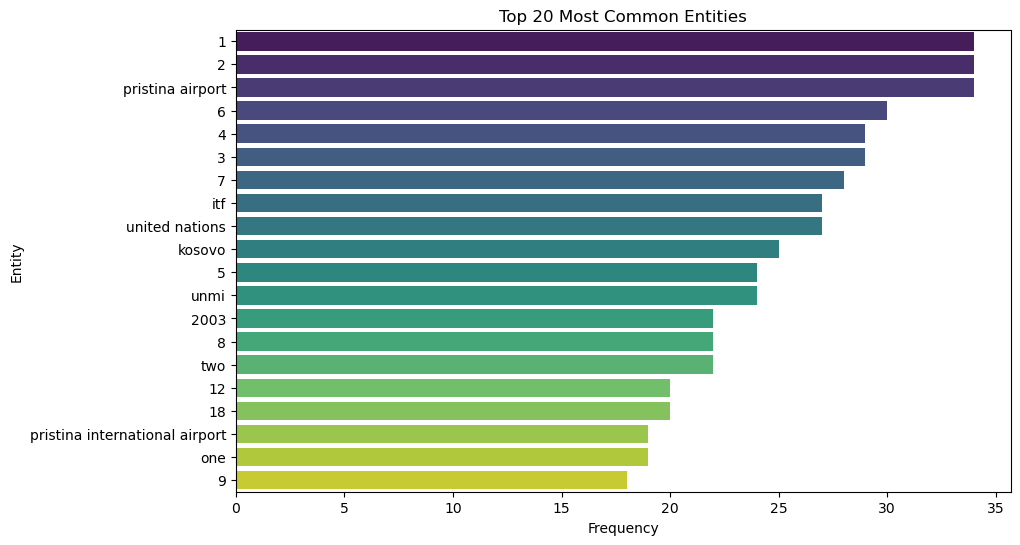

/var/folders/q8/lhzkyp0165j0phc2c182qpq80000gn/T/ipykernel_36056/3462476311.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Label', data=df, palette='Set2')


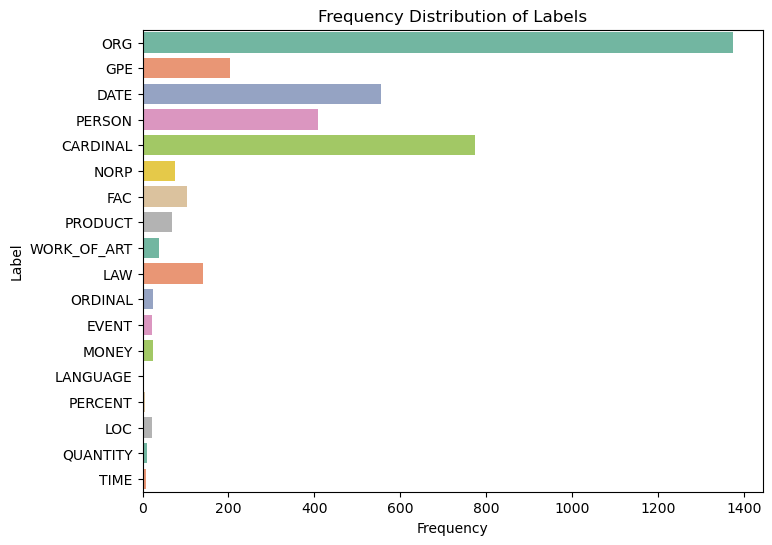

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the top 20 most common entities
top_entities = df['Entity'].value_counts().head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_entities.values, y=top_entities.index, palette='viridis')
plt.title("Top 20 Most Common Entities")
plt.xlabel("Frequency")
plt.ylabel("Entity")
plt.show()
# Plot the frequency distribution of labels
plt.figure(figsize=(8, 6))
sns.countplot(y='Label', data=df, palette='Set2')
plt.title("Frequency Distribution of Labels")
plt.xlabel("Frequency")
plt.ylabel("Label")
plt.show()


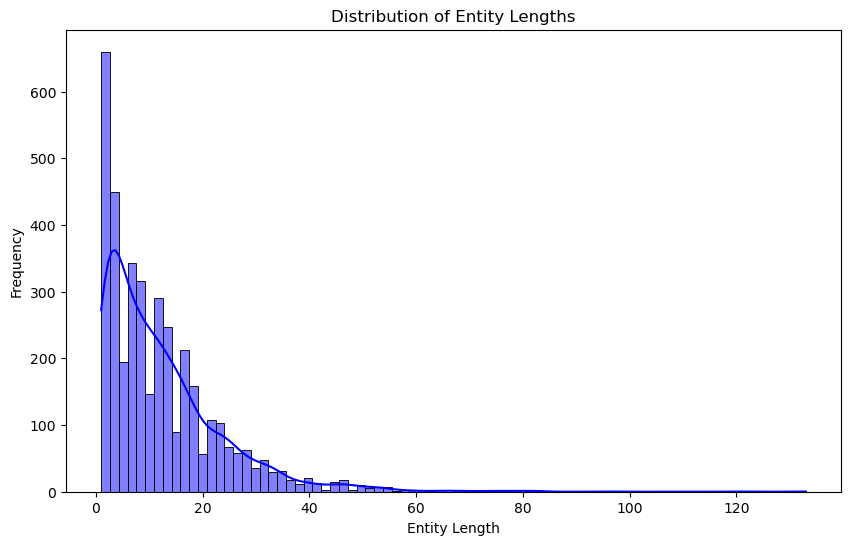

In [74]:
# Create a new column for entity lengths
df['Entity Length'] = df['Entity'].apply(len)

# Plot the distribution of entity lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['Entity Length'], kde=True, color='blue')
plt.title("Distribution of Entity Lengths")
plt.xlabel("Entity Length")
plt.ylabel("Frequency")
plt.show()


In [76]:
# Count the frequency of entity-label pairs
entity_label_pair = df.groupby(['Entity', 'Label']).size().reset_index(name='Frequency')

# Sort and display the top 10 entity-label pairs by frequency
top_entity_label_pairs = entity_label_pair.sort_values('Frequency', ascending=False).head(10)

print(top_entity_label_pairs)


                Entity     Label  Frequency
32                   1  CARDINAL         33
149                  2  CARDINAL         30
273                  3  CARDINAL         28
311                  4  CARDINAL         28
352                  6  CARDINAL         27
2004    united nations       ORG         27
367                  7  CARDINAL         27
330                  5  CARDINAL         24
1376  pristina airport       FAC         23
1052            kosovo       GPE         23


In [78]:
# Count the frequency of entity-label pairs
entity_label_pair = df.groupby(['Entity', 'Label']).size().reset_index(name='Frequency')

# Sort and display the top 10 entity-label pairs by frequency
top_entity_label_pairs = entity_label_pair.sort_values('Frequency', ascending=False).head(10)

print(top_entity_label_pairs)


                Entity     Label  Frequency
32                   1  CARDINAL         33
149                  2  CARDINAL         30
273                  3  CARDINAL         28
311                  4  CARDINAL         28
352                  6  CARDINAL         27
2004    united nations       ORG         27
367                  7  CARDINAL         27
330                  5  CARDINAL         24
1376  pristina airport       FAC         23
1052            kosovo       GPE         23


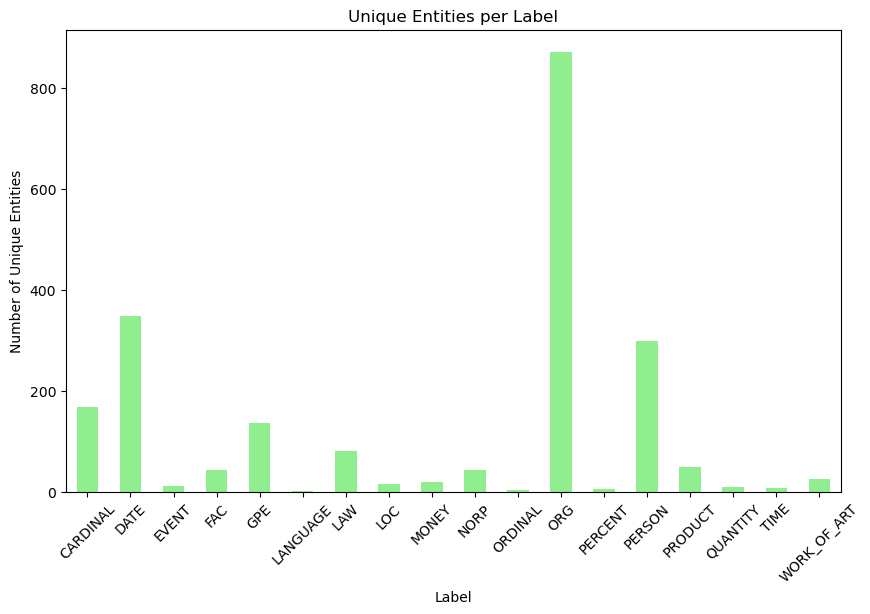

In [84]:
# Count the number of entities per label
entity_count_by_label = df.groupby('Label')['Entity'].nunique()

# Plot the distribution of unique entities across different labels
plt.figure(figsize=(10, 6))
entity_count_by_label.plot(kind='bar', color='lightgreen')
plt.title("Unique Entities per Label")
plt.xlabel("Label")
plt.ylabel("Number of Unique Entities")
plt.xticks(rotation=45)
plt.show()


